In [1]:
import pandas as pd 
import numpy as np
import datetime

pd.set_option('display.max_columns', None)

#load data
df_og = pd.read_csv('../../data/127000_rand.csv')

## Functions

In [25]:
def load_data():
    """
    loads sample data extracted from db
    """
    return pd.read_csv('../../data/db_extracts/large_rand.csv') #change this to the path of file /large_rand.csv 

######Inital Processing######
def remove_rows(df):
    """
    remove outlier rows and certain null values
        - arr_delay outliers above 350 and below -30
        - arr_delay where null
    """

    df = df.loc[(df['arr_delay'].notnull()) | (df['arr_delay'] <= 350)]
    df = df.loc[(df['arr_delay'] <= 350) & (df['arr_delay'] >= -15)]  # play with this
    #df = df.loc[df['taxi_out'] <= 75]
    #df = df.loc[df['taxi_in'] <= 75]

    return df

def create_datetime(df):
    """
    creates columns for month, year, hour onto the dataframe
    """
    df['month'] = pd.DatetimeIndex(df['fl_date']).month
    df['year'] = pd.DatetimeIndex(df['fl_date']).year
    df['day'] = pd.DatetimeIndex(df['fl_date']).dayofweek
    df['dep_hour'] = df['crs_dep_time'].round(-2)/100
    df['arr_hour']= df['crs_arr_time'].round(-2)/100

    return df

def create_is_late(df):
    """
    creates a column 0/1 to indicate if the flight was late or not
    """
    df['is_late'] = df['arr_delay'].apply(lambda x: 1 if x > 0 else 0)

    return df

def create_speed(df):
    """
    create column calculating expected speed of flight. miles/minute
    """
    df['speed'] = (df['distance'] / df['crs_elapsed_time']).round(2)

    return df

def create_route_index(df):
    """
    create key column that combines carrier_origin_dest
    """
    df['route_key'] = df['mkt_carrier'] + "_" + df['origin'] + "_" + df['dest']
    return df

def create_hot_haul(df):
    """
    categorize short/medium/long haul flights w one-hot encoing
    """
    short = df['crs_elapsed_time'].quantile(0.25)
    med = df['crs_elapsed_time'].quantile(0.85)
    long = df['crs_elapsed_time'].quantile(1)
    df['haul'] = df['crs_elapsed_time'].apply(lambda x: 'short' if (x <= short) else ('medium' if x <= med else 'long'))
    temp = pd.get_dummies(df['haul'], prefix='haul')
    df = pd.concat([df, temp], axis=1)

    return df

def create_reduced_flight_delay_column(df):
    """
    add column showing if arr_delay was < dep_delay
    """
    reduced_delay_flight = df['arr_delay'] < df['dep_delay']
    df['reduced_delay_flight'] = 0
    df.loc[reduced_delay_flight, 'reduced_delay_flight'] = 1

    df['taxi_total'] = df['taxi_in'] + df['taxi_out'] ### Cannot use thisss on the final features table
    return df
 

######Table Creations######

    ## Airports Table ##
def create_table_airports(df):
    """
    input flights table and create a unique airports table with stats that will be used for features later
    """
    df_airports = df.copy()
    df_airports = df[['origin_airport_id', 'origin', 'origin_city_name']]
    df_airports = df_airports.drop_duplicates(subset=['origin_airport_id'])
    df_airports.rename(columns={'origin_airport_id': 'airport_id', 'origin':'airport_code'}, inplace=True)
    split = df_airports['origin_city_name'].str.split(",", n=1, expand=True)
    df_airports['city'] = split[0]
    df_airports['state'] = split[1]
    df_airports.drop('origin_city_name', axis=1, inplace=True)
    
    return df_airports

def create_dep_delay(df_flights, df_airports):
    """
    creates a column showing mean departure delay for each airport
    we used mean because previously have 0d out any negatives and mean results in 0 99% of the time
    """
    airports_temp = pd.DataFrame(df_flights.groupby('origin_airport_id').agg('mean')['dep_delay'])
    airports_temp['dep_delay'] = airports_temp['dep_delay'].round(2)
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'origin_airport_id':'airport_id'}, inplace=True)

    df_airports = df_airports.merge(airports_temp, on='airport_id')
    df_airports.rename(columns={'dep_delay':'mean_d_delay'}, inplace=True)


    return df_airports

def create_arr_delay(df_flights, df_airports):
    """
    creates a column showing mean arrival delay for each airport
    we used mean because previously have 0d out any negatives and medium results in 0 99% of the time
    """
    airports_temp = pd.DataFrame(df_flights.groupby('dest_airport_id').agg('mean')['arr_delay'])
    airports_temp['arr_delay'] = airports_temp['arr_delay'].round(2)
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'dest_airport_id':'airport_id'}, inplace=True)

    df_airports = df_airports.merge(airports_temp, on='airport_id')
    df_airports.rename(columns={'arr_delay':'mean_arr_delay'}, inplace=True)

    return df_airports

def create_flight_counts(df_flights, df_airports):
    """
    add columns counting amount of flights in and out of the airports
    this will then be used to calculate a column about % delayed 
    """
    airports_temp = pd.DataFrame(df_flights.groupby('origin_airport_id').count()['flights'])
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'origin_airport_id':'airport_id', 'flights':'dep_flight_count'}, inplace=True)
    df_airports = df_airports.merge(airports_temp, on='airport_id')
    
    airports_temp = pd.DataFrame(df_flights.groupby('dest_airport_id').count()['flights'])
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'dest_airport_id':'airport_id', 'flights':'arr_flight_count'}, inplace=True)
    df_airports = df_airports.merge(airports_temp, on='airport_id')    
    
    return df_airports

def create_delay_counts(df_flights, df_airports):
    """
    create columns counting number of flights lates for depart and arrival airports
    """
    airports_temp = pd.DataFrame(df_flights.groupby(by='origin_airport_id').agg('sum')['is_late'])
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'origin_airport_id':'airport_id', 'is_late':'dep_late_count'}, inplace=True)
    df_airports = df_airports.merge(airports_temp, on='airport_id')

    airports_temp = pd.DataFrame(df_flights.groupby(by='dest_airport_id').agg('sum')['is_late'])
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'dest_airport_id':'airport_id', 'is_late':'arr_late_count'}, inplace=True)
    df_airports = df_airports.merge(airports_temp, on='airport_id')

    return df_airports

def create_late_per(df_airports):
    """
    creates columns showing percent late for arrival and departing airports
    """
    df_airports['dep_late_perc'] = (df_airports['dep_late_count'] / df_airports['dep_flight_count']).round(3)
    df_airports['arr_late_perc'] = (df_airports['arr_late_count'] / df_airports['arr_flight_count']).round(3)

    return df_airports

def create_taxi(df_flights, df_airports):
    """
    add columns shows mean taxi time
    this will then be used to calculate a column about % delayed 
    """
    airports_temp = pd.DataFrame(df_flights.groupby('origin_airport_id').agg('mean')['taxi_out'])
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'origin_airport_id':'airport_id', 'taxi_out':'dep_taxi'}, inplace=True)
    df_airports = df_airports.merge(airports_temp, on='airport_id')
    
    airports_temp = pd.DataFrame(df_flights.groupby('dest_airport_id').agg('mean')['taxi_in'])
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'dest_airport_id':'airport_id', 'taxi_in':'arr_taxi'}, inplace=True)
    df_airports = df_airports.merge(airports_temp, on='airport_id')    
    
    return df_airports

    ## Tail Number Table ##
def create_tail_table(df_flights):
    """
    creates tabel with tail number stats from flights table
    """
    df_tail = df_flights[['tail_num', 'fl_date', 'is_late', 'arr_delay', 'arr_time', 'distance', 'carrier_delay', 
                          'late_aircraft_delay', 'weather_delay']].groupby(by='tail_num').agg({'fl_date':'count', 
                                                                                               'is_late':'sum', 
                                                                                               'arr_delay':['median', 'mean', 'std'],
                                                                                               'arr_time':['median', 'mean'],
                                                                                               'distance':'mean',
                                                                                               'carrier_delay':'count',
                                                                                               'late_aircraft_delay':'count',
                                                                                               'weather_delay':'count'})
    df_tail['late_perc'] = (df_tail['is_late']['sum'] / df_tail['fl_date']['count']).round(3)
    
    #flatterning the multi layered headers for easier use later
    flat_cols = list(df_tail.columns.map('_'.join))
    df_tail.columns = flat_cols

    return df_tail

    ## Carrier Table ##
def create_carrier_table(df_flights):
    """
    creates tabel with carrier stats from flights table
    """
    df_carrier = df_flights[['mkt_carrier', 'fl_date', 'is_late', 
                             'dep_delay', 'arr_delay', 'carrier_delay']].groupby(by='mkt_carrier').agg({'fl_date':'count',
                                                                                           'is_late':'sum',
                                                                                           'dep_delay': 'mean',
                                                                                           'arr_delay': 'mean',
                                                                                           'carrier_delay': 'mean'})
    df_carrier['late_perc'] = (df_carrier['is_late'] / df_carrier['fl_date']).round(3)
    df_carrier['carrier_delay'] = df_carrier['carrier_delay'].round(2)
    df_carrier['dep_delay'] = df_carrier['dep_delay'].round(2)
    df_carrier['arr_delay'] = df_carrier['arr_delay'].round(2)

    return df_carrier
    
def create_carrier_table_v2(df):
    """
    returns new columns for avg taxi in and out based on airports, and total taxi on tail num
    """
    carriers = df.groupby('op_unique_carrier', as_index=False).agg(carrier_arr=('arr_delay', 'mean'), carrier_dep=('dep_delay', 'mean'), carrier_taxiin=('taxi_in', 'mean'), carrier_taxiout=('taxi_out', 'mean'), carrier_late=('is_late', 'sum'), carrier_total=('is_late', 'size'), carrier_reduce_delay=('reduced_delay_flight', 'sum'), reduced_total=('reduced_delay_flight', 'size'))
    carriers['carrier_percent_late'] = carriers['carrier_late'] / carriers['carrier_total'] * 100
    carriers['carrier_taxi_total'] = carriers['carrier_taxiin'] + carriers['carrier_taxiout']
    carriers['percent_carrier_delay_reduced'] = carriers['carrier_reduce_delay'] / carriers['reduced_total'] * 100
    carriers = carriers.drop(columns=['carrier_reduce_delay', 'reduced_total', 'carrier_taxiout', 'carrier_taxiin', 'carrier_total', 'carrier_late'])
    
    #df = df.merge(carriers, on='op_unique_carrier')
    return carriers #df


    ## Hourly Table ##
def create_hourly_table(df_flights):
    """
    creates tabel with hourly stats from flights table
    """
    df_hours = df_flights[['dep_hour', 'fl_date', 'is_late', 
                             'dep_delay', 'arr_delay']].groupby(by='dep_hour').agg({'fl_date':'count',
                                                                                           'is_late':'sum',
                                                                                           'dep_delay': 'mean',
                                                                                           'arr_delay': 'mean'})
    df_hours['late_perc'] = (df_hours['is_late'] / df_hours['fl_date']).round(3)
    df_hours['dep_delay'] = df_hours['dep_delay'].round(2)
    df_hours['arr_delay'] = df_hours['arr_delay'].round(2)

    return df_hours

    ## Hourly v2 Attempt ##
def create_hourly_table_v2(df):
    """
    second attempt at hourly table
    """
    arr_hourly = df.groupby('arr_hour', as_index=False).agg(arr_hourly_arr=('arr_delay', 'mean'), arr_hourly_dep=('dep_delay', 'mean'), arr_hour_taxi=('taxi_total', 'mean'), late=('is_late', 'sum'), ltot=('is_late', 'size'), reduce=('reduced_delay_flight', 'sum'), rtot=('reduced_delay_flight', 'size'))
    arr_hourly['arr_hourly_percent_late'] = arr_hourly['late'] / arr_hourly['ltot'] * 100
    arr_hourly['arr_hourly_percent_reduced_delay'] = arr_hourly['reduce'] / arr_hourly['rtot'] * 100
    arr_hourly = arr_hourly.drop(columns=['late', 'ltot', 'reduce', 'rtot'])
    
    dep_hourly = df.groupby('dep_hour', as_index=False).agg(dep_hourly_arr=('arr_delay', 'mean'), dep_hourly_dep=('dep_delay', 'mean'), dep_hourly_taxi=('taxi_total', 'mean'), late=('is_late', 'sum'), tot=('is_late', 'size'), red=('reduced_delay_flight', 'sum'), rtot=('reduced_delay_flight', 'size'))
    dep_hourly['dep_hourly_percent_late'] = dep_hourly['late'] / dep_hourly['tot'] * 100
    dep_hourly['dep_hourly_percent_reduced'] = dep_hourly['red'] / dep_hourly['rtot'] * 100
    dep_hourly = dep_hourly.drop(columns=['late', 'red', 'tot', 'rtot'])
    
    hourly = pd.concat([arr_hourly, dep_hourly], axis=1).drop('dep_hour', axis=1).rename(columns={'arr_hour':'hour'})

    df.merge(arr_hourly, on='arr_hour')
    df.merge(dep_hourly, on='dep_hour')
    return  hourly #df


    ## Daily Table ##
def create_day_table(df_flights):
    """
    creates tabel with day stats from flights table
    """
    df_days = df_flights[['day', 'fl_date', 'is_late', 
                             'dep_delay', 'arr_delay']].groupby(by='day').agg({'fl_date':'count',
                                                                                           'is_late':'sum',
                                                                                           'dep_delay': 'mean',
                                                                                           'arr_delay': 'mean'})
    df_days['late_perc'] = (df_days['is_late'] / df_days['fl_date']).round(3)
    df_days['dep_delay'] = df_days['dep_delay'].round(2)
    df_days['arr_delay'] = df_days['arr_delay'].round(2)
    
    #bucket carrier category as orginal

    return df_days

def create_day_table_v2(df):
    """
    creates table with weekday stats
    """
    weekday = df.groupby('day', as_index=False).agg(weekday_arr=('arr_delay', 'mean'), weekday_dep=('dep_delay', 'mean'), weekday_taxi=('taxi_total', 'mean'), late=('is_late', 'sum'), tot=('is_late', 'size'), red=('reduced_delay_flight', 'sum'), rtot=('reduced_delay_flight', 'size'))
    weekday['weekday_percent_late'] = weekday['late'] / weekday['tot'] * 100
    weekday['weekday_reduced_delay'] = weekday['red'] / weekday['rtot'] * 100
    weekday = weekday.drop(columns=['red', 'late', 'rtot', 'tot'])

    #df = df.merge(weekday, on='day')
    return weekday 



    ## Route Table ##
def create_route_table(df_flights):
    """
    creates a table with stats about each route for each airline
    """
    routes = df[['route_key', 'dep_delay', 'arr_delay', 'flights']].groupby('route_key').agg({'dep_delay':'mean',
                                                                                              'arr_delay':'mean',
                                                                                              'flights':'count'})
    routes['route_var'] = routes['arr_delay']-routes['dep_delay']
    routes.rename(columns={'dep_delay':'route_dep_delay', 
                           'arr_delay':'route_arr_delay',
                           'flights': 'route_count'}, inplace=True)
    routes.reset_index(inplace=True)
    routes.fillna(0, inplace=True)
    

    return routes


    

###### Exporting Created Tables ######
def save_tables():
    airports.to_csv('../../data/Exported_Tables/stats_airports.csv',  index=False)
    tail.to_csv('../../data/Exported_Tables/stats_tail.csv')
    carrier.to_csv('../../data/Exported_Tables/stats_carrier.csv')
    hourly.to_csv('../../data/Exported_Tables/stats_hourly.csv')
    daily.to_csv('../../data/Exported_Tables/stats_daily.csv')
    routes.to_csv('../../data/Exported_Tables/stats_routes.csv', index=False)

def save_tables_combo():
    airports.to_csv('../../data/Exported_Tables/stats_airports.csv',  index=False)
    tail.to_csv('../../data/Exported_Tables/stats_tail.csv')
    carrier.to_csv('../../data/Exported_Tables/stats_carrier.csv')
    carrier_og.to_csv('../../data/Exported_Tables/stats_carrier_og.csv')
    hourly.to_csv('../../data/Exported_Tables/stats_hourly.csv')
    daily.to_csv('../../data/Exported_Tables/stats_daily.csv')
    routes.to_csv('../../data/Exported_Tables/stats_routes.csv', index=False)

###### Loading Created Tables ######
def load_f_tables():
    airports = pd.read_csv('../../data/Exported_Tables/stats_airports.csv')
    tail = pd.read_csv('../../data/Exported_Tables/stats_tail.csv',index_col='tail_num')
    carrier = pd.read_csv('../../data/Exported_Tables/stats_carrier.csv')
    hourly = pd.read_csv('../../data/Exported_Tables/stats_hourly.csv')
    daily = pd.read_csv('../../data/Exported_Tables/stats_daily.csv') #index_col='day'
    routes = pd.read_csv('../../data/Exported_Tables/stats_routes.csv')

    return airports, tail, carrier, hourly, daily, routes

def load_f_tables_old():
    airports = pd.read_csv('../../data/Exported_Tables/stats_airports.csv')
    tail = pd.read_csv('../../data/Exported_Tables/stats_tail.csv',index_col='tail_num')
    carrier = pd.read_csv('../../data/Exported_Tables/stats_carrier.csv', index_col='mkt_carrier')
    hourly = pd.read_csv('../../data/Exported_Tables/stats_hourly.csv', index_col='dep_hour')
    daily = pd.read_csv('../../data/Exported_Tables/stats_daily.csv', index_col='day')
    routes = pd.read_csv('../../data/Exported_Tables/stats_routes.csv')

    return airports, tail, carrier, hourly, daily, routes

def load_f_tables_fix():
    airports = pd.read_csv('../../data/Exported_Tables/stats_airports.csv')
    tail = pd.read_csv('../../data/Exported_Tables/stats_tail.csv',index_col='tail_num')
    carrier = pd.read_csv('../../data/Exported_Tables/stats_carrier.csv')
    hourly = pd.read_csv('../../data/Exported_Tables/stats_hourly.csv', index_col='dep_hour')
    daily = pd.read_csv('../../data/Exported_Tables/stats_daily.csv')
    routes = pd.read_csv('../../data/Exported_Tables/stats_routes.csv')

    return airports, tail, carrier, hourly, daily, routes

def load_f_tables_combo():
    airports = pd.read_csv('../../data/Exported_Tables/stats_airports.csv')
    tail = pd.read_csv('../../data/Exported_Tables/stats_tail.csv',index_col='tail_num')
    carrier = pd.read_csv('../../data/Exported_Tables/stats_carrier.csv')
    carrier_og = pd.read_csv('../../data/Exported_Tables/stats_carrier_og.csv')
    hourly = pd.read_csv('../../data/Exported_Tables/stats_hourly.csv', index_col='dep_hour')
    daily = pd.read_csv('../../data/Exported_Tables/stats_daily.csv')
    routes = pd.read_csv('../../data/Exported_Tables/stats_routes.csv')

    return airports, tail, carrier, carrier_og, hourly, daily, routes

###### Mearging Features Onto Origional Table ######

def get_features_airport(df_flights, df_airports):
    """
    merges engineered features from the airport stats table onto the main dataframe as additional columns
    """
    airport_dep = df_airports[['airport_id', 'mean_d_delay', 'dep_late_perc', 'dep_taxi']].rename(columns={'mean_d_delay':'air_mean_d_delay', 'dep_late_perc':'air_dep_late_perc', 'dep_taxi':'air_dep_taxi'})
    airport_arr = df_airports[['airport_id', 'mean_arr_delay', 'arr_late_perc', 'arr_taxi']].rename(columns={'mean_arr_delay':'air_mean_arr_delay', 'arr_late_perc':'air_arr_late_perc', 'arr_taxi':'air_arr_taxi'})

    #merge each onto the main dataframe and rename

    df_temp = df_flights.merge(airport_dep, left_on='origin_airport_id', right_on='airport_id')
    df_temp = df_temp.merge(airport_arr, left_on='dest_airport_id', right_on='airport_id')
    df_temp.drop(['airport_id_x', 'airport_id_y'], axis = 1, inplace=True)

    return df_temp

def get_features_hourly(df_flights, df_hourly):
    """
    merges engineered features from the hourly stats table onto the main dataframe as additional columns
    """
    hourly_filter = df_hourly.reset_index()[['dep_hour', 'fl_date', 
                                             'arr_delay', 'late_perc']].rename(columns={'fl_date':'hour_count', 
                                                                                        'arr_delay':'hour_arr_delay',
                                                                                        'late_perc':'hour_late_perc'})
    df_temp = df_flights.merge(hourly_filter, left_on='dep_hour', right_on='dep_hour')
    #df_temp.drop(['airport_id_x', 'airport_id_y'], axis = 1, inplace=True)

    return df_temp

def get_features_hourly_v2(df_flights, df_hourly):
    """
    merges engineered features from the hourly stats table onto the main dataframe as additional columns
    """
    hourly_arr = df_hourly[['hour', 'arr_hourly_arr', 'arr_hourly_dep', 
                            'arr_hour_taxi', 'arr_hourly_percent_late', 'arr_hourly_percent_reduced_delay']]

    hourly_dep = df_hourly[['hour', 'dep_hourly_arr', 'dep_hourly_dep', 
                            'dep_hourly_taxi', 'dep_hourly_percent_late', 'dep_hourly_percent_reduced']]

    df_temp = df_flights.merge(hourly_arr, left_on='arr_hour', right_on='hour')
    df_temp = df_temp.merge(hourly_dep, left_on='dep_hour', right_on='hour')
    #df_temp.drop(['airport_id_x', 'airport_id_y'], axis = 1, inplace=True)

    return df_temp

def get_features_tail(df_flights, df_tail):
    """
    merges engineered features from the Tail Num stats table onto the main dataframe as additional columns
    """
    tail_filter = df_tail.reset_index()[['tail_num', 'fl_date_count', 'arr_delay_mean', 'arr_delay_std', 'late_perc_']]
    tail_filter.rename(columns={'fl_date_count':'tail_count', 'arr_delay_mean':'tail_arr_delay','arr_delay_std':'tail_arr_delay_std' , 'late_perc_':'tail_late_perc'}, inplace=True)
    tail_filter['tail_arr_delay'] = tail_filter['tail_arr_delay'].round(2)
    tail_filter['tail_arr_delay_std'] = tail_filter['tail_arr_delay_std'].round(2)
    tail_filter.drop('tail_arr_delay_std', axis=1, inplace=True)

    df_output = df_flights.merge(tail_filter, left_on='tail_num', right_on='tail_num')

    return df_output

def get_features_carrier(df_flights, df_carrier):
    """
    merges engineered features from carries
    """
    carrier_filter = df_carrier.reset_index()[['mkt_carrier', 'fl_date', 'arr_delay', 
                                               'carrier_delay', 'late_perc']].rename(columns={'fl_date':'carrier_count', 
                                                                                              'arr_delay':'carrier_arr_delay',
                                                                                              'carrier_delay':'carrier_carrier_delay',
                                                                                              'late_perc':'carrier_late_perc'})
    temp = df_flights.merge(carrier_filter, left_on='mkt_carrier', right_on='mkt_carrier')

    return temp

def get_features_carrier_v2(df_flights, df_carrier):
    """
    merges engineered features from carries
    """
    output = df_flights.merge(df_carrier.drop('Unnamed: 0', axis=1), on='op_unique_carrier')

    return output

def get_features_day(df_flights, df_daily):
    daily_filter = df_daily.reset_index()[['day', 'fl_date', 'dep_delay', 'arr_delay', 
                                            'late_perc']].rename(columns={'fl_date':'day_count', 
                                                                          'dep_delay':'day_dep_delay',
                                                                          'arr_delay':'day_arr_delay',
                                                                          'late_perc':'day_late_perc'})
    
    output = df_flights.merge(daily_filter, left_on='day', right_on='day')

    return output 

def get_features_day_v2(df_flights, df_daily):
    output = df_flights.merge(df_daily.drop('Unnamed: 0', axis=1), on='day')
    return output



def get_features_routes(df_flights, df_routes):
    """
    merges wanted features from the routes table
    """
    output = df_flights.merge(df_routes, on='route_key')
    return output


###### Drop Uneeded Columns ######
def drop_it_og(df):
    """
    drop unneeded columns to be used in the model
    """
    output = df.copy().drop(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier','mkt_carrier_fl_num', 
                'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id','origin', 'origin_city_name', 'dest_airport_id',
                'dest', 'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 
                'crs_arr_time', 'arr_time', 'cancelled', 'cancellation_code', 'diverted', 'dup', 'actual_elapsed_time', 'air_time', 'flights',
                'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'first_dep_time', 'total_add_gtime', 
                'longest_add_gtime', 'no_name', 'year', 'route_key', 'is_late', 'haul', 'taxi_total',  'hour_x', 'hour_y'], axis=1)
    return output

def drop_it_old(df):
    """
    drop unneeded columns to be used in the model
    """
    output = df.copy().drop(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier','mkt_carrier_fl_num', 
                'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id','origin', 'origin_city_name', 'dest_airport_id',
                'dest', 'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 
                'crs_arr_time', 'arr_time', 'cancelled', 'cancellation_code', 'diverted', 'dup', 'actual_elapsed_time', 'air_time', 'flights',
                'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'first_dep_time', 'total_add_gtime', 
                'longest_add_gtime', 'no_name', 'year', 'route_key', 'is_late', 'haul', 'taxi_total'], axis=1)
    return output


def drop_it_fix(df):
    """
    drop unneeded columns to be used in the model
    """
    output = df.copy().drop(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier','mkt_carrier_fl_num', 
                'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id','origin', 'origin_city_name', 'dest_airport_id',
                'dest', 'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 
                'crs_arr_time', 'arr_time', 'cancelled', 'cancellation_code', 'diverted', 'dup', 'actual_elapsed_time', 'air_time', 'flights',
                'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'first_dep_time', 'total_add_gtime', 
                'longest_add_gtime', 'no_name', 'year', 'route_key', 'is_late', 'haul', 'taxi_total', 'reduced_delay_flight'], axis=1)
                # 'hour_x', 'hour_y', 
    return output



def save_final_features(df):
    """
    export csv final features table to specificed location
    """
    df.to_csv('../../data/Exported_Tables/final_features.csv')
    return 'Sucessfully exported final features'



###### Transform Jan Test Table ######
def transform_test(data):
    """
    takes the jan test table format and transformes it to a usable state for prediction purposes
    """
    data['dep_hour'] = df['crs_dep_time'].round(-2)/100
    data['arr_hour']= df['crs_arr_time'].round(-2)/100
    data['speed'] = (df['distance'] / df['crs_elapsed_time']).round(2)
    data['route_key'] = df['mkt_carrier'] + "_" + df['origin'] + "_" + df['dest']

    data = get_features_airport(data, airports)
    data = get_features_hourly(data, hourly)
    data = get_features_tail(data, tail)
    data = get_features_carrier(data, carrier)
    data = get_features_day(data, daily)
    data = get_features_routes(data, routes)
    data.drop(['fl_date', 'mkt_unique_carrier','branded_code_share','mkt_carrier','mkt_carrier_fl_num',
               'op_unique_carrier','tail_num','op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
               'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'dup', 
               'flights', 'route_key'], axis=1, inplace=True)

    return data

## Process

In [8]:
#### LOAD & CLEAN ####
df = (
            load_data()
            .pipe(remove_rows)
            .pipe(create_datetime)
            .pipe(create_is_late)
            .pipe(create_speed)
            .pipe(create_route_index)
            .pipe(create_hot_haul)
            .pipe(create_reduced_flight_delay_column)
            )
print('---- Proprocessing Complete! ----')

#### TABLE CREATION ####
# create airport table
airports = create_table_airports(df)
airports = create_dep_delay(df, airports)
airports = create_arr_delay(df, airports)
airports = create_flight_counts(df, airports)
airports = create_delay_counts(df, airports)
airports = create_late_per(airports)
airports = create_taxi(df, airports)
print('---- Airport Table Complete! ----')

# create tail numbers table
tail = create_tail_table(df)
print('---- Tail Table Complete!    ----')

# create carrier table
#carrier = create_carrier_table(df)
carrier = create_carrier_table_v2(df)
print('---- Carrier Table Complete! ----')

# create hourly table
#hourly = create_hourly_table(df)
hourly = create_hourly_table_v2(df) #this is version 2
print('---- hourly Table Complete!  ----')

# create daily table
#daily = create_day_table(df)
daily = create_day_table_v2(df)
print('---- Daily Table Complete!   ----')
# create routes table
routes = create_route_table(df)

# Export all tables for later use #
save_tables()
print('---- Export Tables Complete! ----')

#### Load Created Tables #####
airports, tail, carrier, hourly, daily, routes = load_f_tables()
print('---- Loading Complete!       ----')

#### MERGING TO DF ##### 
df_merged = df.copy()
df_merged = get_features_airport(df_merged, airports)
#df_merged = get_features_hourly(df_merged, hourly)
df_merged = get_features_hourly_v2(df_merged, hourly)
df_merged = get_features_tail(df_merged, tail)
#df_merged = get_features_carrier(df_merged, carrier)
df_merged = get_features_carrier_v2(df_merged, carrier)
df_merged = get_features_day_v2(df_merged, daily)
df_merged = get_features_routes(df_merged, routes)
print('---- Merge Complete!         ----')

#### DROP UNEEEDED ####
df_dropped = drop_it_og(df_merged)
print('---- Final Drop Complete!    ----')

#### DROP UNEEEDED ####
save_final_features(df_dropped)
print('---- Saving Complete!        ----')

---- Proprocessing Complete! ----
---- Airport Table Complete! ----
---- Tail Table Complete!    ----
---- Carrier Table Complete! ----
---- hourly Table Complete!  ----
---- Daily Table Complete!   ----
---- Export Tables Complete! ----
---- Loading Complete!       ----
---- Merge Complete!         ----
---- Final Drop Complete!    ----
---- Saving Complete!        ----


## Process: Old

In [7]:
#### LOAD & CLEAN ####
df = (
            load_data()
            .pipe(remove_rows)
            .pipe(create_datetime)
            .pipe(create_is_late)
            .pipe(create_speed)
            .pipe(create_route_index)
            .pipe(create_hot_haul)
            .pipe(create_reduced_flight_delay_column)
            )
print('---- Proprocessing Complete! ----')

#### TABLE CREATION ####
# create airport table
airports = create_table_airports(df)
airports = create_dep_delay(df, airports)
airports = create_arr_delay(df, airports)
airports = create_flight_counts(df, airports)
airports = create_delay_counts(df, airports)
airports = create_late_per(airports)
airports = create_taxi(df, airports)
print('---- Airport Table Complete! ----')

# create tail numbers table
tail = create_tail_table(df)
print('---- Tail Table Complete!    ----')

# create carrier table
carrier = create_carrier_table(df)
#carrier = create_carrier_table_v2(df)
print('---- Carrier Table Complete! ----')

# create hourly table
hourly = create_hourly_table(df)
#hourly = create_hourly_table_v2(df) #this is version 2
print('---- hourly Table Complete!  ----')

# create daily table
daily = create_day_table(df)
#daily = create_day_table_v2(df)
print('---- Daily Table Complete!   ----')
# create routes table
routes = create_route_table(df)

# Export all tables for later use #
save_tables()
print('---- Export Tables Complete! ----')

#### Load Created Tables #####
airports, tail, carrier, hourly, daily, routes = load_f_tables_old()
print('---- Loading Complete!       ----')

#### MERGING TO DF ##### 
df_merged = df.copy()
df_merged = get_features_airport(df_merged, airports)
df_merged = get_features_hourly(df_merged, hourly)
#df_merged = get_features_hourly_v2(df_merged, hourly)
df_merged = get_features_tail(df_merged, tail)
df_merged = get_features_carrier(df_merged, carrier)
#df_merged = get_features_carrier_v2(df_merged, carrier)
df_merged = get_features_day(df_merged, daily)
#df_merged = get_features_day_v2(df_merged, daily)
df_merged = get_features_routes(df_merged, routes)
print('---- Merge Complete!         ----')

#### DROP UNEEEDED ####
df_dropped = drop_it_old(df_merged)
print('---- Final Drop Complete!    ----')

#### DROP UNEEEDED ####
save_final_features(df_dropped)
print('---- Saving Complete!        ----')

---- Proprocessing Complete! ----
---- Airport Table Complete! ----
---- Tail Table Complete!    ----
---- Carrier Table Complete! ----
---- hourly Table Complete!  ----
---- Daily Table Complete!   ----
---- Export Tables Complete! ----
---- Loading Complete!       ----
---- Merge Complete!         ----
---- Final Drop Complete!    ----
---- Saving Complete!        ----


In [8]:
df_dropped

,arr_delay,crs_elapsed_time,distance,month,day,dep_hour,arr_hour,speed,haul_long,haul_medium,haul_short,reduced_delay_flight,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_count,carrier_arr_delay,carrier_carrier_delay,carrier_late_perc,day_count,day_dep_delay,day_arr_delay,day_late_perc,route_dep_delay,route_arr_delay,route_count,route_var
0,-4.0,102,554,6,3,10.0,12.0,5.43,0,1,0,1,13.05,0.470,17.183099,6.98,0.387,9.230421,6216,8.14,0.409,19,-0.42,0.316,19824,9.68,18.70,0.406,14613,13.87,12.72,0.472,5.970588,8.235294,34,2.264706
1,56.0,114,554,11,3,18.0,20.0,4.86,0,1,0,0,13.05,0.470,17.183099,6.98,0.387,9.230421,6130,19.16,0.537,21,4.67,0.238,19824,9.68,18.70,0.406,14613,13.87,12.72,0.472,5.970588,8.235294,34,2.264706
2,1.0,107,554,9,3,18.0,20.0,5.18,0,1,0,0,13.05,0.470,17.183099,6.98,0.387,9.230421,6130,19.16,0.537,19,8.58,0.368,19824,9.68,18.70,0.406,14613,13.87,12.72,0.472,5.970588,8.235294,34,2.264706
3,2.0,104,554,5,3,6.0,7.0,5.33,0,1,0,0,13.05,0.470,17.183099,6.98,0.387,9.230421,6576,3.14,0.327,26,14.92,0.462,19824,9.68,18.70,0.406,14613,13.87,12.72,0.472,5.970588,8.235294,34,2.264706
4,0.0,107,554,11,3,5.0,7.0,5.18,0,1,0,0,13.05,0.470,17.183099,6.98,0.387,9.230421,1732,2.91,0.300,9,3.44,0.333,19824,9.68,18.70,0.406,14613,13.87,12.72,0.472,5.970588,8.235294,34,2.264706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95796,14.0,102,696,6,6,14.0,16.0,6.82,0,1,0,0,14.28,0.556,11.555556,10.37,0.464,5.552486,6034,12.91,0.469,18,26.83,0.556,1315,14.10,20.97,0.465,13388,14.20,12.55,0.455,8.000000,14.000000,1,6.000000
95797,39.0,143,999,7,6,19.0,21.0,6.99,0,1,0,0,13.05,0.470,17.183099,19.30,0.457,5.928571,4798,19.54,0.550,13,1.85,0.308,1315,14.10,20.97,0.465,13388,14.20,12.55,0.455,36.000000,39.000000,1,3.000000
95798,12.0,320,2504,3,6,15.0,24.0,7.82,1,0,0,1,-0.29,0.298,11.591160,10.24,0.482,12.780741,5717,16.48,0.506,4,-1.00,0.500,1329,2.83,23.46,0.376,13388,14.20,12.55,0.455,24.000000,12.000000,1,-12.000000
95799,-8.0,345,2457,1,6,9.0,13.0,7.12,1,0,0,1,9.81,0.399,12.974063,2.11,0.310,6.526316,5081,6.83,0.394,7,7.00,0.429,1329,2.83,23.46,0.376,13388,14.20,12.55,0.455,6.000000,-8.000000,1,-14.000000


In [6]:
df_dropped.isnull().sum()

arr_delay                0
crs_elapsed_time         0
distance                 0
month                    0
day                      0
dep_hour                 0
arr_hour                 0
speed                    0
haul_long                0
haul_medium              0
haul_short               0
reduced_delay_flight     0
air_mean_d_delay         0
air_dep_late_perc        0
air_dep_taxi             0
air_mean_arr_delay       0
air_arr_late_perc        0
air_arr_taxi             0
hour_count               0
hour_arr_delay           0
hour_late_perc           0
tail_count               0
tail_arr_delay           0
tail_late_perc           0
carrier_count            0
carrier_arr_delay        0
carrier_carrier_delay    0
carrier_late_perc        0
day_count                0
day_dep_delay            0
day_arr_delay            0
day_late_perc            0
route_dep_delay          0
route_arr_delay          0
route_count              0
route_var                0
dtype: int64

## Process: Fix

In [13]:
#this just is figuring out wtf is going on with the hours stuff!!

#### LOAD & CLEAN ####
df = (
            load_data()
            .pipe(remove_rows)
            .pipe(create_datetime)
            .pipe(create_is_late)
            .pipe(create_speed)
            .pipe(create_route_index)
            .pipe(create_hot_haul)
            .pipe(create_reduced_flight_delay_column)
            )
print('---- Proprocessing Complete! ----')

#### TABLE CREATION ####
# create airport table
airports = create_table_airports(df)
airports = create_dep_delay(df, airports)
airports = create_arr_delay(df, airports)
airports = create_flight_counts(df, airports)
airports = create_delay_counts(df, airports)
airports = create_late_per(airports)
airports = create_taxi(df, airports)
print('---- Airport Table Complete! ----')

# create tail numbers table
tail = create_tail_table(df)
print('---- Tail Table Complete!    ----')

# create carrier table
#carrier = create_carrier_table(df)
carrier = create_carrier_table_v2(df)
print('---- Carrier Table Complete! ----')

# create hourly table
hourly = create_hourly_table(df)
#hourly = create_hourly_table_v2(df) #this is version 2    this dude right here is an issueeeee
print('---- hourly Table Complete!  ----')

# create daily table
#daily = create_day_table(df)
daily = create_day_table_v2(df)
print('---- Daily Table Complete!   ----')
# create routes table
routes = create_route_table(df)

# Export all tables for later use #
save_tables()
print('---- Export Tables Complete! ----')

#### Load Created Tables #####
airports, tail, carrier, hourly, daily, routes = load_f_tables_fix()
print('---- Loading Complete!       ----')

#### MERGING TO DF ##### 
df_merged = df.copy()
df_merged = get_features_airport(df_merged, airports)
df_merged = get_features_hourly(df_merged, hourly)
#df_merged = get_features_hourly_v2(df_merged, hourly)
df_merged = get_features_tail(df_merged, tail)
#df_merged = get_features_carrier(df_merged, carrier)
df_merged = get_features_carrier_v2(df_merged, carrier)
#df_merged = get_features_day(df_merged, daily)
df_merged = get_features_day_v2(df_merged, daily)
df_merged = get_features_routes(df_merged, routes)
print('---- Merge Complete!         ----')

#### DROP UNEEEDED ####
df_dropped = drop_it_fix(df_merged)
print('---- Final Drop Complete!    ----')

#### DROP UNEEEDED ####
save_final_features(df_dropped)
print('---- Saving Complete!        ----')

---- Proprocessing Complete! ----
---- Airport Table Complete! ----
---- Tail Table Complete!    ----
---- Carrier Table Complete! ----
---- hourly Table Complete!  ----
---- Daily Table Complete!   ----
---- Export Tables Complete! ----
---- Loading Complete!       ----
---- Merge Complete!         ----
---- Final Drop Complete!    ----
---- Saving Complete!        ----


## Process: Combo

In [26]:
#this just is figuring out wtf is going on with the hours stuff!!

#### LOAD & CLEAN ####
df = (
            load_data()
            .pipe(remove_rows)
            .pipe(create_datetime)
            .pipe(create_is_late)
            .pipe(create_speed)
            .pipe(create_route_index)
            .pipe(create_hot_haul)
            .pipe(create_reduced_flight_delay_column)
            )
print('---- Proprocessing Complete! ----')

#### TABLE CREATION ####
# create airport table
airports = create_table_airports(df)
airports = create_dep_delay(df, airports)
airports = create_arr_delay(df, airports)
airports = create_flight_counts(df, airports)
airports = create_delay_counts(df, airports)
airports = create_late_per(airports)
airports = create_taxi(df, airports)
print('---- Airport Table Complete! ----')

# create tail numbers table
tail = create_tail_table(df)
print('---- Tail Table Complete!    ----')

# create carrier table
carrier_og = create_carrier_table(df)
carrier = create_carrier_table_v2(df)
print('---- Carrier Table Complete! ----')

# create hourly table
hourly = create_hourly_table(df)
#hourly = create_hourly_table_v2(df) #this is version 2    this dude right here is an issueeeee
print('---- hourly Table Complete!  ----')

# create daily table
#daily = create_day_table(df)
daily = create_day_table_v2(df)
print('---- Daily Table Complete!   ----')
# create routes table
routes = create_route_table(df)

# Export all tables for later use #
save_tables_combo()
print('---- Export Tables Complete! ----')

#### Load Created Tables #####
## airports, tail, carrier, hourly, daily, routes = load_f_tables_fix()
airports, tail, carrier, carrier_og, hourly, daily, routes = load_f_tables_combo()
print('---- Loading Complete!       ----')

#### MERGING TO DF ##### 
df_merged = df.copy()
df_merged = get_features_airport(df_merged, airports)
df_merged = get_features_hourly(df_merged, hourly)
#df_merged = get_features_hourly_v2(df_merged, hourly)
df_merged = get_features_tail(df_merged, tail)
df_merged = get_features_carrier(df_merged, carrier_og)
df_merged = get_features_carrier_v2(df_merged, carrier)
#df_merged = get_features_day(df_merged, daily)
df_merged = get_features_day_v2(df_merged, daily)
df_merged = get_features_routes(df_merged, routes)
print('---- Merge Complete!         ----')

#### DROP UNEEEDED ####
df_dropped = drop_it_fix(df_merged)
print('---- Final Drop Complete!    ----')

#### DROP UNEEEDED ####
save_final_features(df_dropped)
print('---- Saving Complete!        ----')

FileNotFoundError: [Errno 2] No such file or directory: '../../data/db_extracts/large_rand.csv'

In [23]:
#df_dropped.drop(['arr_hourly_arr', 'arr_hourly_dep', 'arr_hour_taxi', 'dep_hourly_arr', 'dep_hourly_dep', 'dep_hourly_taxi', 'arr_hourly_percent_late', 'arr_hourly_percent_reduced_delay', 'dep_hourly_percent_late', 'dep_hourly_percent_reduced'], axis=1, inplace=True)

df_dropped

,arr_delay,crs_elapsed_time,distance,month,day,dep_hour,arr_hour,speed,haul_long,haul_medium,haul_short,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_count,carrier_arr_delay,carrier_carrier_delay,carrier_late_perc,carrier_arr,carrier_dep,carrier_percent_late,carrier_taxi_total,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var
0,-4.0,102,554,6,3,10.0,12.0,5.43,0,1,0,13.05,0.470,17.183099,6.98,0.387,9.230421,6216,8.14,0.409,19,-0.42,0.316,19824,9.68,18.70,0.406,7.131836,10.131214,38.219105,26.328924,69.105114,12.72326,13.869080,26.880657,47.197701,61.335797,5.970588,8.235294,34,2.264706
1,56.0,114,554,11,3,18.0,20.0,4.86,0,1,0,13.05,0.470,17.183099,6.98,0.387,9.230421,6130,19.16,0.537,21,4.67,0.238,19824,9.68,18.70,0.406,7.131836,10.131214,38.219105,26.328924,69.105114,12.72326,13.869080,26.880657,47.197701,61.335797,5.970588,8.235294,34,2.264706
2,1.0,107,554,9,3,18.0,20.0,5.18,0,1,0,13.05,0.470,17.183099,6.98,0.387,9.230421,6130,19.16,0.537,19,8.58,0.368,19824,9.68,18.70,0.406,7.131836,10.131214,38.219105,26.328924,69.105114,12.72326,13.869080,26.880657,47.197701,61.335797,5.970588,8.235294,34,2.264706
3,2.0,104,554,5,3,6.0,7.0,5.33,0,1,0,13.05,0.470,17.183099,6.98,0.387,9.230421,6576,3.14,0.327,26,14.92,0.462,19824,9.68,18.70,0.406,7.131836,10.131214,38.219105,26.328924,69.105114,12.72326,13.869080,26.880657,47.197701,61.335797,5.970588,8.235294,34,2.264706
4,0.0,107,554,11,3,5.0,7.0,5.18,0,1,0,13.05,0.470,17.183099,6.98,0.387,9.230421,1732,2.91,0.300,9,3.44,0.333,19824,9.68,18.70,0.406,7.131836,10.131214,38.219105,26.328924,69.105114,12.72326,13.869080,26.880657,47.197701,61.335797,5.970588,8.235294,34,2.264706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95796,14.0,102,696,6,6,14.0,16.0,6.82,0,1,0,14.28,0.556,11.555556,10.37,0.464,5.552486,6034,12.91,0.469,18,26.83,0.556,1315,14.10,20.97,0.465,14.098099,14.147529,46.463878,20.707985,55.361217,12.54870,14.199791,26.218246,45.518375,64.064834,8.000000,14.000000,1,6.000000
95797,39.0,143,999,7,6,19.0,21.0,6.99,0,1,0,13.05,0.470,17.183099,19.30,0.457,5.928571,4798,19.54,0.550,13,1.85,0.308,1315,14.10,20.97,0.465,14.098099,14.147529,46.463878,20.707985,55.361217,12.54870,14.199791,26.218246,45.518375,64.064834,36.000000,39.000000,1,3.000000
95798,12.0,320,2504,3,6,15.0,24.0,7.82,1,0,0,-0.29,0.298,11.591160,10.24,0.482,12.780741,5717,16.48,0.506,4,-1.00,0.500,1329,2.83,23.46,0.376,2.125513,1.244463,36.833470,19.524200,45.200984,12.54870,14.199791,26.218246,45.518375,64.064834,24.000000,12.000000,1,-12.000000
95799,-8.0,345,2457,1,6,9.0,13.0,7.12,1,0,0,9.81,0.399,12.974063,2.11,0.310,6.526316,5081,6.83,0.394,7,7.00,0.429,1329,2.83,23.46,0.376,2.125513,1.244463,36.833470,19.524200,45.200984,12.54870,14.199791,26.218246,45.518375,64.064834,6.000000,-8.000000,1,-14.000000


# Linear Regression Test

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [24]:
df = df_dropped

X = np.array(df.drop('arr_delay', axis=1))
y = np.array(df['arr_delay'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=69) 

reg = LinearRegression()
reg.fit(X_train,y_train)

print("Train R2:", reg.score(X_train, y_train))
print("Test R2:", reg.score(X_test, y_test))

Train R2: 0.1878140123295795
Test R2: 0.1947434896853103


# Transforming Test Table

In [42]:
df_test = pd.read_csv('../../data/db_extracts/flights_test.csv')
df_test_transformed = df_test.copy()
df_test_transformed = transform_test(df_test)


df_test_transformed.to_csv('../../data/Exported_Tables/X_test_real.csv')

In [43]:
df_test_transformed

,crs_elapsed_time,distance,month,day,dep_hour,arr_hour,speed,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_count,carrier_arr_delay,carrier_carrier_delay,carrier_late_perc,day_count,day_dep_delay,day_arr_delay,day_late_perc,route_dep_delay,route_arr_delay,route_count,route_var
0,95,363,1,3,15.0,16.0,3.56,5.92,0.301,11.496901,8.83,0.401,8.549240,36672,7.09,0.388,185,2.82,0.357,106319,3.49,16.51,0.364,92233,10.05,5.64,0.372,-3.0,1.088235,34,4.088235
1,121,620,1,3,15.0,16.0,3.33,10.18,0.371,22.060101,2.43,0.376,5.096078,36672,7.09,0.388,120,4.82,0.400,120847,6.55,15.72,0.362,92233,10.05,5.64,0.372,-3.0,1.088235,34,4.088235
2,175,978,1,3,15.0,16.0,3.56,5.46,0.320,13.858680,2.39,0.393,9.964247,36672,7.09,0.388,99,8.18,0.495,33451,0.59,12.34,0.352,92233,10.05,5.64,0.372,-3.0,1.088235,34,4.088235
3,119,551,1,3,15.0,16.0,3.56,8.51,0.314,16.719732,4.43,0.350,5.575926,36672,7.09,0.388,123,1.66,0.317,137949,0.64,18.38,0.291,92233,10.05,5.64,0.372,-3.0,1.088235,34,4.088235
4,161,1005,1,1,15.0,16.0,3.33,12.08,0.419,23.038196,5.48,0.361,9.337009,36672,7.09,0.388,82,10.11,0.366,120847,6.55,15.72,0.362,89649,8.44,3.33,0.334,-3.0,1.088235,34,4.088235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619999,40,100,1,0,11.0,13.0,6.20,2.20,0.347,10.589962,-0.13,0.335,7.510488,36694,1.72,0.320,215,0.54,0.353,7311,0.49,22.26,0.333,93581,10.04,5.10,0.358,-4.0,-3.000000,1,1.000000
620000,42,100,1,0,11.0,13.0,4.41,1.70,0.310,15.632421,-1.06,0.301,6.768895,36694,1.72,0.320,240,-0.31,0.304,7311,0.49,22.26,0.333,93581,10.04,5.10,0.358,73.0,44.000000,1,-29.000000
620001,256,1576,1,0,9.0,12.0,5.81,8.66,0.347,22.615398,8.25,0.429,6.057171,33772,-0.39,0.297,124,7.80,0.419,9978,9.62,17.97,0.422,93581,10.04,5.10,0.358,-5.0,-22.000000,1,-17.000000
620002,89,349,1,0,20.0,23.0,7.28,10.95,0.382,18.060786,4.32,0.371,5.385531,34086,9.00,0.417,135,6.44,0.467,9978,9.62,17.97,0.422,93581,10.04,5.10,0.358,-8.0,-22.000000,1,-14.000000


In [32]:
def transform_test(data):
    data['dep_hour'] = df['crs_dep_time'].round(-2)/100
    data['arr_hour']= df['crs_arr_time'].round(-2)/100
    data['speed'] = (df['distance'] / df['crs_elapsed_time']).round(2)
    data['route_key'] = df['mkt_carrier'] + "_" + df['origin'] + "_" + df['dest']

    data = get_features_airport(data, airports)
    data = get_features_hourly(data, hourly)
    data = get_features_tail(data, tail)
    data = get_features_carrier(data, carrier)
    data = get_features_day(data, daily)
    data = get_features_routes(data, routes)
    data.drop(['fl_date', 'mkt_unique_carrier','branded_code_share','mkt_carrier','mkt_carrier_fl_num',
               'op_unique_carrier','tail_num','op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
               'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'dup', 
               'flights', 'route_key'], axis=1, inplace=True)

    return data


# Scrap

In [56]:
df

,arr_delay,crs_elapsed_time,distance,month,day,dep_hour,arr_hour,speed,haul_long,haul_medium,haul_short,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_count,carrier_arr_delay,carrier_carrier_delay,carrier_late_perc,day_count,day_dep_delay,day_arr_delay,day_late_perc,route_dep_delay,route_arr_delay,route_count,route_var
0,-4.0,102,554,6,3,10.0,12.0,5.43,0,1,0,13.05,0.470,17.183099,6.98,0.387,9.230421,6216,8.14,0.409,19,-0.42,0.316,19824,9.68,18.70,0.406,14613,13.87,12.72,0.472,5.970588,8.235294,34,2.264706
1,56.0,114,554,11,3,18.0,20.0,4.86,0,1,0,13.05,0.470,17.183099,6.98,0.387,9.230421,6130,19.16,0.537,21,4.67,0.238,19824,9.68,18.70,0.406,14613,13.87,12.72,0.472,5.970588,8.235294,34,2.264706
2,1.0,107,554,9,3,18.0,20.0,5.18,0,1,0,13.05,0.470,17.183099,6.98,0.387,9.230421,6130,19.16,0.537,19,8.58,0.368,19824,9.68,18.70,0.406,14613,13.87,12.72,0.472,5.970588,8.235294,34,2.264706
3,2.0,104,554,5,3,6.0,7.0,5.33,0,1,0,13.05,0.470,17.183099,6.98,0.387,9.230421,6576,3.14,0.327,26,14.92,0.462,19824,9.68,18.70,0.406,14613,13.87,12.72,0.472,5.970588,8.235294,34,2.264706
4,0.0,107,554,11,3,5.0,7.0,5.18,0,1,0,13.05,0.470,17.183099,6.98,0.387,9.230421,1732,2.91,0.300,9,3.44,0.333,19824,9.68,18.70,0.406,14613,13.87,12.72,0.472,5.970588,8.235294,34,2.264706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95796,14.0,102,696,6,6,14.0,16.0,6.82,0,1,0,14.28,0.556,11.555556,10.37,0.464,5.552486,6034,12.91,0.469,18,26.83,0.556,1315,14.10,20.97,0.465,13388,14.20,12.55,0.455,8.000000,14.000000,1,6.000000
95797,39.0,143,999,7,6,19.0,21.0,6.99,0,1,0,13.05,0.470,17.183099,19.30,0.457,5.928571,4798,19.54,0.550,13,1.85,0.308,1315,14.10,20.97,0.465,13388,14.20,12.55,0.455,36.000000,39.000000,1,3.000000
95798,12.0,320,2504,3,6,15.0,24.0,7.82,1,0,0,-0.29,0.298,11.591160,10.24,0.482,12.780741,5717,16.48,0.506,4,-1.00,0.500,1329,2.83,23.46,0.376,13388,14.20,12.55,0.455,24.000000,12.000000,1,-12.000000
95799,-8.0,345,2457,1,6,9.0,13.0,7.12,1,0,0,9.81,0.399,12.974063,2.11,0.310,6.526316,5081,6.83,0.394,7,7.00,0.429,1329,2.83,23.46,0.376,13388,14.20,12.55,0.455,6.000000,-8.000000,1,-14.000000


In [46]:
df_og.describe()

,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
count,127480.000000,127480.000000,127480.000000,127480.000000,127480.000000,125470.000000,125428.000000,125347.000000,125347.000000,125266.000000,125266.000000,127480.000000,125318.000000,125019.000000,127480.000000,127480.000000,127480.000000,125040.000000,124988.000000,127480.0,127480.000000,23973.000000,23973.000000,23973.000000,23973.000000,23973.000000,926.000000,926.000000,926.000000,0.0
mean,2741.065610,2741.023408,12683.967862,12681.825400,1328.642673,1333.328971,10.450529,17.529083,1357.680838,1458.134386,7.674565,1483.251906,1462.294810,5.382942,0.016512,0.002628,137.585692,132.761876,107.613571,1.0,765.136100,20.716556,3.660660,16.258791,0.113795,26.760773,1330.872570,40.988121,40.160907,NaN
std,1864.834469,1864.855953,1524.223521,1523.048401,489.998024,503.853182,48.156672,10.070085,505.313573,533.043086,6.099779,517.128568,537.448909,50.297246,0.127436,0.051195,71.396730,71.337065,69.338578,0.0,581.793873,63.766765,35.129313,39.355802,6.773971,52.319510,497.667655,35.998602,34.364045,NaN
min,1.000000,1.000000,10135.000000,10135.000000,4.000000,1.000000,-41.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,-99.000000,0.000000,0.000000,20.000000,16.000000,8.000000,1.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,1.000000,NaN
25%,1131.000000,1131.000000,11292.000000,11292.000000,915.000000,917.000000,-6.000000,11.000000,932.000000,1043.000000,4.000000,1100.000000,1047.000000,-15.000000,0.000000,0.000000,87.000000,82.000000,58.000000,1.0,341.000000,0.000000,0.000000,0.000000,0.000000,0.000000,854.000000,18.000000,18.000000,NaN
50%,2320.000000,2320.000000,12889.000000,12889.000000,1320.000000,1325.000000,-2.000000,15.000000,1339.000000,1457.000000,6.000000,1511.000000,1501.000000,-6.000000,0.000000,0.000000,119.000000,114.000000,89.000000,1.0,602.000000,0.000000,0.000000,3.000000,0.000000,3.000000,1344.000000,31.000000,30.000000,NaN
75%,4333.000000,4333.000000,14057.000000,14057.000000,1735.000000,1743.000000,7.000000,20.000000,1759.000000,1909.000000,9.000000,1915.000000,1913.000000,8.000000,0.000000,0.000000,167.000000,162.000000,136.000000,1.0,998.000000,18.000000,0.000000,20.000000,0.000000,33.000000,1733.750000,49.000000,48.000000,NaN
max,9388.000000,9388.000000,16869.000000,16869.000000,2359.000000,2400.000000,2710.000000,194.000000,2400.000000,2400.000000,164.000000,2400.000000,2400.000000,2692.000000,1.000000,1.000000,1512.000000,698.000000,648.000000,1.0,5095.000000,2315.000000,2692.000000,1234.000000,987.000000,1368.000000,2400.000000,232.000000,229.000000,NaN


In [45]:
df_dropped.describe()

,arr_delay,crs_elapsed_time,distance,month,day,dep_hour,arr_hour,speed,haul_long,haul_medium,haul_short,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_count,carrier_arr_delay,carrier_carrier_delay,carrier_late_perc,day_count,day_dep_delay,day_arr_delay,day_late_perc,route_dep_delay,route_arr_delay,route_count,route_var
count,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.00000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000,121582.000000
mean,4.958571,136.221497,757.134757,6.591601,2.937795,13.144355,14.681877,4.983622,0.148640,0.598033,0.253327,9.357753,0.358692,17.590539,4.958652,0.358678,7.696081,7044.947180,4.95858,0.358753,24.255194,4.958716,0.358708,22878.158107,4.960084,16.986496,0.358680,17429.987663,9.357912,4.957054,0.358737,9.357487,4.958571,28.075587,-4.398990
std,37.699183,70.155038,573.951017,3.381002,1.994074,4.901193,5.179596,1.448055,0.355735,0.490297,0.434918,3.615608,0.048214,3.802733,3.611024,0.043261,2.775629,1520.762411,4.87760,0.064711,8.586600,9.633925,0.122101,8886.212723,2.855264,2.169686,0.034764,972.513399,0.974225,1.227450,0.018848,11.113962,11.744986,20.129599,4.363131
min,-30.000000,20.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.730000,0.000000,0.000000,0.000000,-15.330000,0.000000,2.583333,-18.000000,0.000000,1.250000,23.000000,-3.16000,0.222000,1.000000,-29.000000,0.000000,125.000000,-0.180000,11.110000,0.300000,15015.000000,7.950000,2.540000,0.321000,-24.000000,-30.000000,1.000000,-44.000000
25%,-14.000000,86.000000,338.000000,4.000000,1.000000,9.000000,11.000000,3.990000,0.000000,0.000000,0.000000,7.260000,0.329000,14.831418,2.800000,0.341000,5.379182,6710.000000,0.43000,0.303000,18.000000,-1.480000,0.278000,20993.000000,1.690000,15.450000,0.358000,17147.000000,8.140000,4.080000,0.349000,2.545455,-2.100000,14.000000,-6.967742
50%,-6.000000,118.000000,599.000000,7.000000,3.000000,13.000000,15.000000,5.110000,0.000000,1.000000,0.000000,9.420000,0.362000,17.318182,4.590000,0.365000,7.142027,7225.000000,5.31000,0.366000,24.000000,3.440000,0.357000,23358.000000,5.720000,17.130000,0.370000,17606.000000,9.920000,5.180000,0.355000,7.977778,3.304348,24.000000,-4.590909
75%,8.000000,165.000000,989.000000,10.000000,5.000000,17.000000,19.000000,6.060000,0.000000,1.000000,1.000000,11.640000,0.384000,19.887594,6.480000,0.382000,8.977246,8025.000000,9.30000,0.426000,30.000000,9.580000,0.435000,31597.000000,7.420000,18.700000,0.374000,18162.000000,10.260000,6.100000,0.377000,13.968750,9.892857,38.000000,-1.960000
max,350.000000,690.000000,5095.000000,12.000000,6.000000,24.000000,24.000000,9.990000,1.000000,1.000000,1.000000,59.140000,1.000000,31.500000,100.500000,1.000000,13.991962,8860.000000,26.87000,0.457000,61.000000,247.000000,1.000000,31597.000000,13.140000,23.460000,0.450000,18164.000000,10.370000,6.380000,0.383000,363.000000,339.000000,175.000000,81.000000


/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='arr_delay', ylabel='Density'>

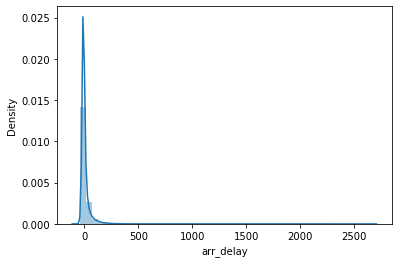

In [41]:
sns.distplot(df_og['arr_delay'])

In [17]:
df_og['crs_elapsed_time'].quantile(0.85)

200.0

In [41]:
df_dropped

,arr_delay,crs_elapsed_time,distance,month,day,dep_hour,arr_hour,speed,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_count,carrier_arr_delay,carrier_carrier_delay,carrier_late_perc,day_count,day_dep_delay,day_arr_delay,day_late_perc,route_dep_delay,route_arr_delay,route_count,route_var
0,67.0,45,160,5,6,15.0,16.0,3.56,-0.29,0.288,13.861981,1.50,0.391,3.843750,36672,7.09,0.388,135,-5.31,0.222,33451,0.59,12.34,0.352,88708,9.05,3.77,0.344,-3.0,1.088235,34,4.088235
1,-3.0,49,160,11,6,15.0,16.0,3.27,-0.29,0.288,13.861981,1.50,0.391,3.843750,36672,7.09,0.388,132,-5.30,0.235,33451,0.59,12.34,0.352,88708,9.05,3.77,0.344,-3.0,1.088235,34,4.088235
2,1.0,47,160,4,6,15.0,16.0,3.40,-0.29,0.288,13.861981,1.50,0.391,3.843750,36672,7.09,0.388,148,-4.11,0.257,33451,0.59,12.34,0.352,88708,9.05,3.77,0.344,-3.0,1.088235,34,4.088235
3,-6.0,50,160,1,6,15.0,16.0,3.20,-0.29,0.288,13.861981,1.50,0.391,3.843750,36672,7.09,0.388,94,0.32,0.298,33451,0.59,12.34,0.352,88708,9.05,3.77,0.344,-3.0,1.088235,34,4.088235
4,6.0,45,160,3,5,15.0,16.0,3.56,-0.29,0.288,13.861981,1.50,0.391,3.843750,36672,7.09,0.388,135,-5.31,0.222,33451,0.59,12.34,0.352,76006,7.10,1.02,0.308,-3.0,1.088235,34,4.088235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623415,19.0,211,1514,6,2,16.0,21.0,7.18,7.37,0.318,13.910368,9.54,0.449,6.225316,36801,8.39,0.405,73,5.27,0.438,7938,6.25,20.01,0.379,90814,8.01,3.26,0.342,29.0,19.000000,1,-10.000000
623416,-14.0,161,1090,11,2,8.0,11.0,6.77,6.36,0.279,10.659574,3.55,0.274,4.197115,42868,-0.81,0.294,93,11.76,0.398,7938,6.25,20.01,0.379,90814,8.01,3.26,0.342,-15.0,-14.000000,1,1.000000
623417,18.0,217,1550,6,2,6.0,11.0,7.14,8.15,0.324,18.227439,4.75,0.355,6.479798,44842,-3.98,0.237,99,-2.83,0.343,7938,6.25,20.01,0.379,90814,8.01,3.26,0.342,-1.0,18.000000,1,19.000000
623418,48.0,158,1117,7,2,9.0,12.0,7.07,7.88,0.321,13.797566,9.54,0.449,6.225316,33772,-0.39,0.297,88,9.84,0.477,7938,6.25,20.01,0.379,90814,8.01,3.26,0.342,44.0,48.000000,1,4.000000


In [54]:
routes.fillna(0).isnull().sum()

route_key          0
route_dep_delay    0
route_arr_delay    0
route_count        0
route_var          0
dtype: int64

In [10]:
df
df['mkt_carrier'] + "_" + df['origin'] + "_" + df['dest']

0         AS_ANC_CDV
1         AS_ATL_SEA
2         AS_PDX_ANC
3         AS_EWR_SFO
4         AS_SEA_IAH
             ...    
637436    UA_IAH_BNA
637437    UA_MCI_IAH
637438    UA_ORD_OKC
637439    WN_ABQ_PHX
637440    AS_JNU_YAK
Length: 623434, dtype: object

In [25]:
routes = df[['route_key', 'dep_delay', 'arr_delay']].groupby('route_key').agg('mean')
routes.head(10)

,dep_delay,arr_delay
route_key,,
AA_ABE_CLT,1.623529,-2.035294
AA_ABE_ORD,6.392857,0.285714
AA_ABE_PHL,-3.800000,-2.146667
AA_ABI_DFW,6.029240,3.631579
AA_ABQ_DFW,4.253731,0.144279
AA_ABQ_LAX,-1.764045,-3.898876
AA_ABQ_ORD,8.962264,3.452830
AA_ABQ_PHX,7.639344,2.254098
AA_ACK_CLT,-5.000000,-19.000000


In [38]:
routes = create_route_table(df)
routes

,route_key,route_dep_delay,route_arr_delay,route_count,route_var
0,AA_ABE_CLT,1.623529,-2.035294,85,-3.658824
1,AA_ABE_ORD,6.392857,0.285714,28,-6.107143
2,AA_ABE_PHL,-3.800000,-2.146667,75,1.653333
3,AA_ABI_DFW,6.029240,3.631579,171,-2.397661
4,AA_ABQ_DFW,4.253731,0.144279,201,-4.109453
...,...,...,...,...,...
9855,WN_TUS_LAX,7.358974,3.217949,78,-4.141026
9856,WN_TUS_MDW,0.294118,-8.323529,34,-8.617647
9857,WN_TUS_OAK,8.000000,-6.000000,1,-14.000000
9858,WN_TUS_SAN,3.066667,-3.283333,60,-6.350000


In [41]:
get_features_routes(df, routes)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,month,year,day,dep_hour,arr_hour,is_late,speed,route_key,route_dep_delay,route_arr_delay,route_count,route_var
0,2019-05-19,AS,AS,AS,66,AS,N619AS,66,10299,ANC,"Anchorage, AK",10926,CDV,"Cordova, AK",1525,1624.0,59.0,14.0,1638.0,1713.0,4.0,1610,1717.0,67.0,0,NaN,0,N,45,53.0,35.0,1,160,59.0,0.0,8.0,0.0,0.0,1532.0,17.0,17.0,NaN,5,2019,6,15.0,16.0,1,3.56,AS_ANC_CDV,-3.0,1.088235,34,4.088235
1,2019-04-10,AS,AS,AS,66,AS,N607AS,66,10299,ANC,"Anchorage, AK",10926,CDV,"Cordova, AK",1525,1518.0,-7.0,15.0,1533.0,1608.0,4.0,1610,1612.0,2.0,0,NaN,0,N,45,54.0,35.0,1,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2019,2,15.0,16.0,1,3.56,AS_ANC_CDV,-3.0,1.088235,34,4.088235
2,2019-04-17,AS,AS,AS,66,AS,N593AS,66,10299,ANC,"Anchorage, AK",10926,CDV,"Cordova, AK",1525,1519.0,-6.0,20.0,1539.0,1615.0,4.0,1610,1619.0,9.0,0,NaN,0,N,45,60.0,36.0,1,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2019,2,15.0,16.0,1,3.56,AS_ANC_CDV,-3.0,1.088235,34,4.088235
3,2019-03-23,AS,AS,AS,66,AS,N619AS,66,10299,ANC,"Anchorage, AK",10926,CDV,"Cordova, AK",1525,1519.0,-6.0,17.0,1536.0,1613.0,3.0,1610,1616.0,6.0,0,NaN,0,N,45,57.0,37.0,1,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2019,5,15.0,16.0,1,3.56,AS_ANC_CDV,-3.0,1.088235,34,4.088235
4,2019-07-25,AS,AS,AS,66,AS,N612AS,66,10299,ANC,"Anchorage, AK",10926,CDV,"Cordova, AK",1510,1514.0,4.0,23.0,1537.0,1607.0,4.0,1600,1611.0,11.0,0,NaN,0,N,50,57.0,30.0,1,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,2019,3,15.0,16.0,1,3.20,AS_ANC_CDV,-3.0,1.088235,34,4.088235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623429,2019-05-04,WN,WN,WN,2513,WN,N8631A,2513,12953,LGA,"New York, NY",14027,PBI,"West Palm Beach/Palm Beach, FL",1215,1209.0,-6.0,26.0,1235.0,1514.0,4.0,1520,1518.0,-2.0,0,NaN,0,N,185,189.0,159.0,1,1035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2019,5,12.0,15.0,0,5.59,WN_LGA_PBI,-6.0,-2.000000,1,4.000000
623430,2019-05-12,AA,AA_CODESHARE,AA,4619,YX,N107HQ,4619,11278,DCA,"Washington, DC",13360,MLB,"Melbourne, FL",845,840.0,-5.0,23.0,903.0,1101.0,7.0,1110,1108.0,-2.0,0,NaN,0,N,145,148.0,118.0,1,769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2019,6,8.0,11.0,0,5.30,AA_DCA_MLB,-5.0,-2.000000,1,3.000000
623431,2019-05-16,G4,G4,G4,1619,G4,247NV,1619,12223,HTS,"Ashland, WV",14082,PGD,"Punta Gorda, FL",848,852.0,4.0,6.0,858.0,1039.0,5.0,1048,1044.0,-4.0,0,NaN,0,N,120,112.0,101.0,1,790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2019,3,8.0,10.0,0,6.58,G4_HTS_PGD,4.0,-4.000000,1,-8.000000
623432,2019-05-18,NK,NK,NK,397,NK,N534NK,397,13198,MCI,"Kansas City, MO",13577,MYR,"Myrtle Beach, SC",940,1027.0,47.0,13.0,1040.0,1341.0,7.0,1305,1348.0,43.0,0,NaN,0,N,145,141.0,121.0,1,959,0.0,0.0,0.0,0.0,43.0,NaN,NaN,NaN,NaN,5,2019,5,9.0,13.0,1,6.61,NK_MCI_MYR,47.0,43.000000,1,-4.000000


In [40]:
df

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,month,year,day,dep_hour,arr_hour,is_late,speed,route_key
0,2019-05-19,AS,AS,AS,66,AS,N619AS,66,10299,ANC,"Anchorage, AK",10926,CDV,"Cordova, AK",1525,1624.0,59.0,14.0,1638.0,1713.0,4.0,1610,1717.0,67.0,0,NaN,0,N,45,53.0,35.0,1,160,59.0,0.0,8.0,0.0,0.0,1532.0,17.0,17.0,NaN,5,2019,6,15.0,16.0,1,3.56,AS_ANC_CDV
1,2019-05-19,AS,AS,AS,85,AS,N265AK,85,10397,ATL,"Atlanta, GA",14747,SEA,"Seattle, WA",625,622.0,-3.0,15.0,637.0,813.0,8.0,845,821.0,-24.0,0,NaN,0,N,320,299.0,276.0,1,2182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2019,6,6.0,8.0,0,6.82,AS_ATL_SEA
2,2019-05-19,AS,AS,AS,143,AS,N590AS,143,14057,PDX,"Portland, OR",10299,ANC,"Anchorage, AK",2040,2032.0,-8.0,16.0,2048.0,2249.0,4.0,2320,2253.0,-27.0,0,NaN,0,N,220,201.0,181.0,1,1542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2019,6,20.0,23.0,0,7.01,AS_PDX_ANC
3,2019-05-19,AS,AS,AS,317,AS,N442AS,317,11618,EWR,"Newark, NJ",14771,SFO,"San Francisco, CA",1940,2148.0,128.0,119.0,2347.0,224.0,7.0,2305,231.0,206.0,0,NaN,0,N,385,463.0,337.0,1,2565,0.0,0.0,78.0,0.0,128.0,NaN,NaN,NaN,NaN,5,2019,6,19.0,23.0,1,6.66,AS_EWR_SFO
4,2019-05-19,AS,AS,AS,350,AS,N495AS,350,14747,SEA,"Seattle, WA",12266,IAH,"Houston, TX",1200,1201.0,1.0,28.0,1229.0,1827.0,11.0,1820,1838.0,18.0,0,NaN,0,N,260,277.0,238.0,1,1874,0.0,0.0,18.0,0.0,0.0,NaN,NaN,NaN,NaN,5,2019,6,12.0,18.0,1,7.21,AS_SEA_IAH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637436,2019-05-19,UA,UA_CODESHARE,UA,3601,YX,N651RW,3601,12266,IAH,"Houston, TX",10693,BNA,"Nashville, TN",1620,1620.0,0.0,24.0,1644.0,1811.0,31.0,1817,1842.0,25.0,0,NaN,0,N,117,142.0,87.0,1,657,0.0,0.0,25.0,0.0,0.0,NaN,NaN,NaN,NaN,5,2019,6,16.0,18.0,1,5.62,UA_IAH_BNA
637437,2019-05-19,UA,UA_CODESHARE,UA,3611,YX,N729YX,3611,13198,MCI,"Kansas City, MO",12266,IAH,"Houston, TX",1830,1907.0,37.0,15.0,1922.0,2102.0,7.0,2037,2109.0,32.0,0,NaN,0,N,127,122.0,100.0,1,643,0.0,0.0,0.0,0.0,32.0,NaN,NaN,NaN,NaN,5,2019,6,18.0,20.0,1,5.06,UA_MCI_IAH
637438,2019-05-19,UA,UA_CODESHARE,UA,3615,YX,N650RW,3615,13930,ORD,"Chicago, IL",13851,OKC,"Oklahoma City, OK",1246,1319.0,33.0,28.0,1347.0,1549.0,7.0,1507,1556.0,49.0,0,NaN,0,N,141,157.0,122.0,1,693,33.0,0.0,16.0,0.0,0.0,NaN,NaN,NaN,NaN,5,2019,6,12.0,15.0,1,4.91,UA_ORD_OKC
637439,2019-05-19,WN,WN,WN,2980,WN,N296WN,2980,10140,ABQ,"Albuquerque, NM",14107,PHX,"Phoenix, AZ",1420,1450.0,30.0,9.0,1459.0,1457.0,6.0,1435,1503.0,28.0,0,NaN,0,N,75,73.0,58.0,1,328,10.0,0.0,0.0,0.0,18.0,NaN,NaN,NaN,NaN,5,2019,6,14.0,14.0,1,4.37,WN_ABQ_PHX


In [22]:
df.describe()

,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,month,year,day,dep_hour,arr_hour,is_late,speed
count,623434.000000,623434.000000,623434.000000,623434.000000,623434.000000,623434.000000,623262.000000,623190.000000,623190.000000,623189.000000,623189.000000,623434.000000,623433.000000,623434.000000,623434.0,623434.0,623434.000000,623433.000000,623189.00000,623434.0,623434.000000,118674.000000,118674.000000,118674.000000,118674.000000,118674.000000,3720.000000,3720.000000,3720.000000,0.0,623434.000000,623434.000000,623434.000000,623434.000000,623434.000000,623434.000000,623434.000000
mean,2724.716876,2724.651408,12677.266299,12678.546318,1328.498824,1333.911673,9.005641,17.512728,1358.559699,1459.691915,7.669418,1483.037754,1464.069841,3.998816,0.0,0.0,138.166197,133.161350,108.01793,1.0,771.014975,16.713914,2.835432,15.679281,0.092767,25.538054,1326.218548,35.402419,35.064516,NaN,6.585493,2018.507390,2.935397,13.150194,14.694444,0.348547,4.996167
std,1863.357531,1863.383216,1523.241185,1523.318306,489.908779,503.698231,35.110530,10.023355,505.053520,532.220984,6.073373,516.931400,536.490019,37.989566,0.0,0.0,71.989516,71.797057,69.85365,0.0,588.822895,36.687724,17.685611,30.149760,2.765911,44.276667,492.109796,29.185670,28.808398,NaN,3.399466,0.499946,1.996044,4.905533,5.180856,0.476511,1.511757
min,1.000000,1.000000,10135.000000,10135.000000,1.000000,1.000000,-141.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,-230.000000,0.0,0.0,-35.000000,16.000000,8.00000,1.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,NaN,1.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,-18.600000
25%,1115.000000,1115.000000,11292.000000,11292.000000,915.000000,917.000000,-6.000000,11.000000,933.000000,1044.000000,4.000000,1100.000000,1048.000000,-15.000000,0.0,0.0,87.000000,82.000000,58.00000,1.0,341.000000,0.000000,0.000000,0.000000,0.000000,0.000000,858.000000,16.000000,16.000000,NaN,4.000000,2018.000000,1.000000,9.000000,11.000000,0.000000,3.990000
50%,2301.000000,2301.000000,12889.000000,12889.000000,1320.000000,1326.000000,-2.000000,15.000000,1341.000000,1459.000000,6.000000,1510.000000,1503.000000,-6.000000,0.0,0.0,119.000000,115.000000,89.00000,1.0,604.000000,0.000000,0.000000,3.000000,0.000000,3.000000,1339.000000,27.000000,27.000000,NaN,7.000000,2019.000000,3.000000,13.000000,15.000000,0.000000,5.120000
75%,4309.000000,4308.000000,14057.000000,14057.000000,1735.000000,1744.000000,6.000000,20.000000,1759.000000,1909.000000,9.000000,1915.000000,1914.000000,8.000000,0.0,0.0,168.000000,163.000000,137.00000,1.0,1008.000000,17.000000,0.000000,20.000000,0.000000,33.000000,1732.000000,43.000000,43.000000,NaN,10.000000,2019.000000,5.000000,17.000000,19.000000,1.000000,6.080000
max,9390.000000,9390.000000,16869.000000,16869.000000,2359.000000,2400.000000,383.000000,178.000000,2400.000000,2400.000000,212.000000,2400.000000,2400.000000,350.000000,0.0,0.0,1542.000000,725.000000,696.00000,1.0,5095.000000,350.000000,350.000000,349.000000,291.000000,350.000000,2357.000000,216.000000,216.000000,NaN,12.000000,2019.000000,6.000000,24.000000,24.000000,1.000000,318.000000
